In [1]:
%load_ext autoreload
%autoreload 2

In [595]:
import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as plt

from learning import lstd, valuefunc
from env import linearenv, controller
from exputils import relerr
from trajgen import quadratic

## I. Learning LQR

In [779]:
p = 5
q = 3
T = 10
num_trajs = 1000
gamma = 0.99

In [830]:
lqrenv = linearenv.random_vanilla_env(p, q, QRratio=10, Anorm=1.05)
xtraj, _, utraj, rtraj, xtraj_, _ = lqrenv.sampletraj(lqrenv.randctrl(), 10, num_trajs)

In [831]:
# Test policy evaluation
Pstar, Kstar = lqrenv.solve(None)
Pxuhat, Pxhat = lstd.evaluate(xtraj, utraj, rtraj, xtraj_, Kstar, gamma, sigma=0)
error = exputils.relerr(Pstar, Pxhat)
print('Relative evaluation error (Fro norm) is {:6.3f}%'.format(error * 100))

Relative evaluation error (Fro norm) is  4.835%


Iteration:     0, |P - P_new|:	  27.112
Iteration:     1, |P - P_new|:	  27.117
Iteration:     2, |P - P_new|:	   1.734
Iteration:     3, |P - P_new|:	   0.357
Iteration:     4, |P - P_new|:	   0.035
Iteration:     5, |P - P_new|:	   0.000


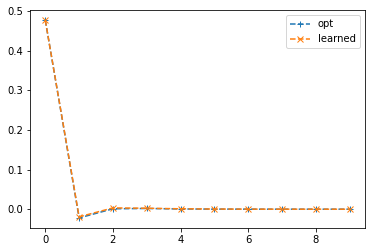

In [832]:
# Test policy iteration
K, P = lstd.lspi(xtraj, utraj, rtraj, xtraj_, gamma, verbose=True)
# Simulate learned trajectory
x0 = np.random.rand(1, p)
learnedctrl = controller.LinearFbController(K)
x, _, u, r, _, _ = lqrenv.sampletraj(learnedctrl, T, 1, x0s=x0)
# Simulate optimal trajectory
optctrl = controller.LinearFbController(Kstar)
xopt, _, uopt, ropt, _, _ = lqrenv.sampletraj(optctrl, T, 1, x0s=x0)
# Plot trajectory
ind = 0
plt.plot(np.arange(T), xopt[:, ind], '+--', label='opt')
plt.plot(np.arange(T), x[:, ind], 'x--', label='learned')
_ = plt.legend()

## II. LQR tracking control

In [83]:
p = 2
q = 2
Tref = 15
sigma_w = 0
gamma = 0.999
num_traj = 2000

In [84]:
# Learn a tracking controller from least squares policy iteration
lqrenv = linearenv.random_vanilla_env(p, q, QRratio=100, Anorm=0.995)
lqrenv.sigma_w = sigma_w
trackingenv = lqrenv.totracking(Tref)
samplingctrl = trackingenv.randctrl()
x, _, u, r, x_, _ = trackingenv.sampletraj(samplingctrl, Tref, num_traj)
Pstar, Kstar = trackingenv.solve(None)
K, P = lstd.lspi(x, u, r, x_, gamma, verbose=True)

Iteration:     0, |P - P_new|:	  18.193
Iteration:     1, |P - P_new|:	  17.996
Iteration:     2, |P - P_new|:	   0.137
Iteration:     3, |P - P_new|:	   0.000


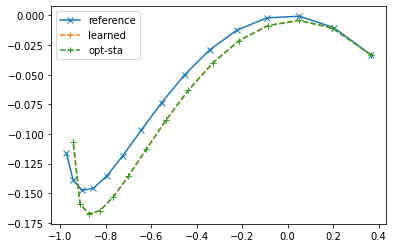

In [94]:
# Generate a random reference trajectory
ts = np.linspace(0, 1, Tref)- np.random.random()
ref = np.vstack([ts**2 - 2 * ts, ts**3 - ts**2]).flatten('F')
d0 = np.concatenate([ref[0:2], ref])

# Simulate
learnedctrl = controller.LinearFbController(K)
optctrl = controller.LinearFbController(Kstar)
xlearn, _, _, _, _, _ = trackingenv.sampletraj(learnedctrl, Tref, 1, x0s=d0[None, :])
xopt, _, _, _, _, _ = trackingenv.sampletraj(optctrl, Tref, 1, x0s=d0[None, :])

# Plot
plt.plot(ref[0::2], ref[1::2], 'x-', label='reference')
plt.plot(xlearn[:,0], xlearn[:, 1], '+--', label='learned')
plt.plot(xopt[:,0], xopt[:, 1], '+--', label='opt-sta')
plt.legend()

## III. Trajectory generation with dynamic regularization

In [447]:
p = 2
q = 2
Tref = 25
sigma_w = 0
gamma = 0.999
num_traj = 900

In [571]:
# Learn value of the given controller
lqrenv = linearenv.random_vanilla_env(p, q, QRratio=100, Anorm=0.995)
lqrenv.sigma_w = sigma_w
trackingenv = lqrenv.totracking(Tref)
Pstar, Kstar = trackingenv.solve()
samplingctrl = trackingenv.optctrl()
x, _, u, r, x_, _ = trackingenv.sampletraj(samplingctrl, Tref, num_traj)
_, P = lstd.evaluate(x, u, r, x_, Kstar, gamma, sigma=sigma_w)

# Regularize P so that it's psd
mineig = np.abs(np.linalg.eigvals(P).min())
if mineig < 0:
    P = P + (np.eye(P.shape[0]) * (mineig + 1e-3))
else:
    P = P + (np.eye(P.shape[0]) * 1e-3)
error = relerr(Pstar, P)
print('Relative evaluation error (Fro norm) is {:6.3f}%'.format(error * 100))

Relative evaluation error (Fro norm) is  0.166%


In [572]:
# Specify waypoints
waypoints = [[0,0],
             [np.random.randn(), np.random.randn()],
             [np.random.randn(), np.random.randn()],
             [1,1]]
waypoints = np.array(waypoints)
ts = [0, 0.33, 0.66, 1]

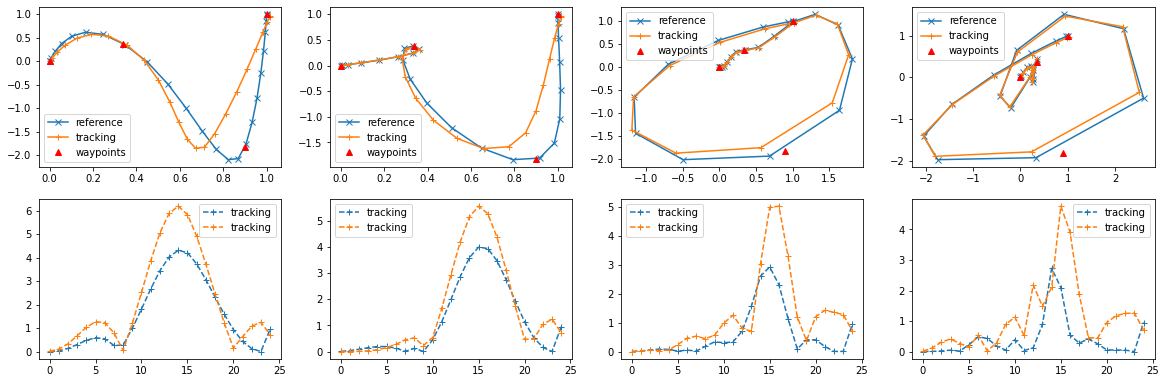

In [596]:
# Spline trajectory
rhos = np.concatenate([[0], np.logspace(4, 8, 3)])
optctrl = trackingenv.optctrl(Tref)

plt.figure(figsize=(20, 10))
for i, rho in enumerate(rhos):
    ref = quadratic.generate(waypoints, ts, 5, Tref, p, P=Pstar, rho=rho)
    d0 = np.concatenate([waypoints[0], ref])
    
    xopt, _, uopt, ropt, _, _ = trackingenv.sampletraj(optctrl, Tref, 1, x0s=d0[None, :])
    
    plt.subplot(3, len(rhos), i+1+len(rhos))
    plt.plot(ref[0::p], ref[1::p], 'x-', label='reference')
    plt.plot(xopt[:,0], xopt[:,1], '+-', label='tracking')
    plt.plot(waypoints[:,0], waypoints[:,1], 'r^', label='waypoints')
    plt.legend()
    
    plt.subplot(3, len(rhos), i+1+2*len(rhos))
    plt.plot(np.arange(Tref), np.abs(uopt), '+--', label='tracking')
    plt.legend()